# ACBD6 and NEDPM Syndrome

[Neurodevelopmental Disorder with Progressive Movement Abnormalities (NEDPM)](https://www.omim.org/entry/620785) is an autosomal recessive complex neurologic disorder characterized by global developmental delay apparent from infancy, moderately to severely impaired intellectual development, poor or absent speech, behavioral abnormalities, and various hyperkinetic movement disorders, including dystonia, spasticity, and cerebellar ataxia, that interfere with gait and cause a stooped posture. NEDPM is caused by pathogenic variants in the [ACBD6](https://www.omim.org/entry/616352?search=acbd6&highlight=acbd6) gene.

[Kaiyrzhanov et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/37951597/) did not identify significant genotype-phenotype correlations.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.9.6.dev0


## Loading Phenopackets & Gene Variant Data

In [2]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = 'ACBD6'
phenopacket_store_release = '0.1.24'


registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 45/45 [00:00<00:00, 63.85 individuals/s]
Validated under permissive policy
No errors or warnings were found


## ACBD6
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ACBD6.

In [3]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'ACBD6'
mane_tx_id = 'NM_032360.4'
mane_protein_id = "NP_115736.1"

pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
45,Global developmental delay
36,Delayed speech and language development
33,Ataxia
32,Delayed ability to walk
29,Stooped posture
27,Lower limb spasticity
24,Depressed nasal bridge
24,Wide nose
23,Thin upper lip vermilion
22,Coarse facial features


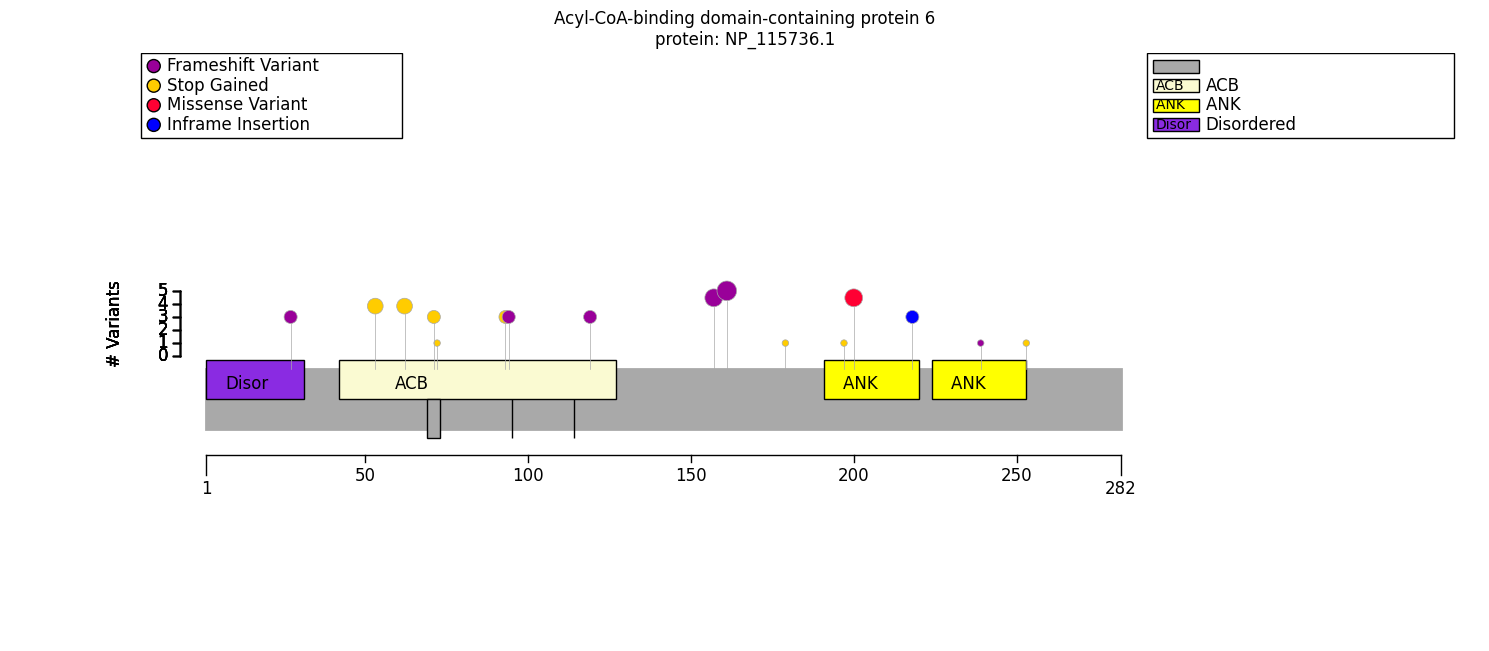

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

abdc6_fig, acadm_ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=acadm_ax,
)
abdc6_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
2,Disordered,Region,2 - 31,p.Val28GlyfsTer6
15,ACB,Domain,43 - 127,p.Glu63Ter; p.Gln54Ter; p.Tyr72Ter; p.Lys95AsnfsTer23; p.Leu121ThrfsTer27; p.Lys73Ter; p.Gln94Ter
3,,Binding site,70 - 73,p.Tyr72Ter; p.Lys73Ter
0,,Binding site,96 - 95,
0,,Binding site,115 - 114,
7,ANK 1,Repeat,192 - 220,p.Asp201Gly; p.Asn219dup; p.Trp198Ter
1,ANK 2,Repeat,225 - 253,p.Ile240ArgfsTer9


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
partitions = ({0,1}, {2,})
missense = biallelic_classifier(a_predicate=is_missense, 
                                   b_predicate=~is_missense, 
                                   a_label="missense",
                                   b_label="other",
                                   partitions=partitions)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense,
    pheno_clfs=pheno_clfs,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,9
"Skipping ""general"" level terms",66
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),101


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense OR missense/other,other/other,Corrected p values,p values
Self-injurious behavior [HP:0100716],3/4 (75%),5/30 (17%),1.0,0.032905
Partial agenesis of the corpus callosum [HP:0001338],2/4 (50%),2/41 (5%),1.0,0.034129
Deeply set eye [HP:0000490],4/4 (100%),12/29 (41%),1.0,0.044477
Urinary incontinence [HP:0000020],4/4 (100%),9/19 (47%),1.0,0.104461
Frequent temper tantrums [HP:0025161],4/4 (100%),15/32 (47%),1.0,0.106205
...,...,...,...,...
Delayed ability to walk [HP:0031936],4/4 (100%),28/29 (97%),1.0,1.000000
Delayed speech and language development [HP:0000750],4/4 (100%),37/37 (100%),1.0,1.000000
Abnormal communication [HP:0034434],4/4 (100%),37/37 (100%),1.0,1.000000
Global developmental delay [HP:0001263],4/4 (100%),41/41 (100%),1.0,1.000000


In [10]:
from gpsea.analysis.predicate import protein_feature

acb = protein_feature(feature_id="ACB", protein_metadata=protein_meta)

acb_clf = biallelic_classifier(a_predicate=acb, 
                                    b_predicate=~acb, 
                                    partitions=({0,1}, {2,}), 
                                   a_label="ACB",
                                   b_label="other")
acb_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=acb_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=acb_result)

Allele group,ACB/ACB OR ACB/other,other/other,Corrected p values,p values
Depressed nasal bridge [HP:0005280],9/9 (100%),15/27 (56%),0.808775,0.016339
Wide nose [HP:0000445],9/9 (100%),15/27 (56%),0.808775,0.016339
Autistic behavior [HP:0000729],7/9 (78%),6/18 (33%),1.000000,0.046072
Thin upper lip vermilion [HP:0000219],2/7 (29%),21/29 (72%),1.000000,0.073308
Mandibular prognathia [HP:0000303],0/8 (0%),9/26 (35%),1.000000,0.076970
...,...,...,...,...
Upper motor neuron dysfunction [HP:0002493],9/9 (100%),22/22 (100%),1.000000,1.000000
Hypertonia [HP:0001276],9/9 (100%),22/22 (100%),1.000000,1.000000
Abnormal muscle tone [HP:0003808],9/9 (100%),22/22 (100%),1.000000,1.000000
Delayed gross motor development [HP:0002194],9/9 (100%),23/23 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Aggressive behavior [HP:0000718],3/16 (19%),11/21 (52%),1.0,0.047534
Lower limb spasticity [HP:0002061],10/17 (59%),17/20 (85%),1.0,0.136271
Upslanted palpebral fissure [HP:0000582],11/16 (69%),9/21 (43%),1.0,0.184525
Tics [HP:0100033],1/6 (17%),6/13 (46%),1.0,0.333075
Coarse facial features [HP:0000280],8/16 (50%),14/21 (67%),1.0,0.335514
...,...,...,...,...
Urinary incontinence [HP:0000020],7/12 (58%),6/11 (55%),1.0,1.000000
Everted lower lip vermilion [HP:0000232],7/15 (47%),9/20 (45%),1.0,1.000000
Abnormal facial shape [HP:0001999],8/8 (100%),14/14 (100%),1.0,1.000000
Abnormal temper tantrums [HP:0025160],9/9 (100%),10/10 (100%),1.0,1.000000


# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


mono_results = (
    GPAnalysisResultSummary.from_multi(
         result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result = acb_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result = mf_result,
    ),
)

acbd6_caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=mono_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=acbd6_caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense/missense OR missense/other,other/other,99,0
Genotype (A),Genotype (B),Tests performed,Significant tests
ACB/ACB OR ACB/other,other/other,99,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,99,0


In [14]:
summarizer.process_latex(report=report,protein_fig=abdc6_fig)

Figure saved to ../../supplement/img/ACBD6_protein_diagram-draft.pdf
Output to ../../supplement/tex/ACBD6_summary_draft.tex
